Imports and Data Loading

In [99]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import os

# --- Configuration ---
DATA_PATH = '/content/retail_store_inventory.csv'
PRODUCT_ID = 'P0001'
RESULTS_DIR = '../results/' # Directory to save plots

# Ensure the results directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load the dataset
df = pd.read_csv(DATA_PATH)

print("Data loaded successfully.")
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Info:")
df.info()

Data loaded successfully.
First 5 rows of the dataset:
         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-01     S001      P0002         Toys  South              204   
2  2022-01-01     S001      P0003         Toys   West              102   
3  2022-01-01     S001      P0004         Toys  North              469   
4  2022-01-01     S001      P0005  Electronics   East              166   

   Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0         127             55           135.47  33.50        20   
1         150             66           144.04  63.01        20   
2          65             51            74.02  27.99        10   
3          61            164            62.18  32.72        10   
4          14            135             9.26  73.64         0   

  Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0             Rainy           

Data Preprocessing and Filtering

In [100]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter data for a specific product, e.g., 'P0001'
product_df = df[df['Product ID'] == PRODUCT_ID].copy()
product_df.sort_values(by='Date', inplace=True) # Ensure data is sorted by date

print(f"\nFiltered data for Product ID '{PRODUCT_ID}' head:")
print(product_df.head())
print(f"\nFiltered data for Product ID '{PRODUCT_ID}' info:")
product_df.info()


Filtered data for Product ID 'P0001' head:
         Date Store ID Product ID   Category Region  Inventory Level  \
0  2022-01-01     S001      P0001  Groceries  North              231   
20 2022-01-01     S002      P0001  Groceries  South              343   
40 2022-01-01     S003      P0001       Toys  South              241   
60 2022-01-01     S004      P0001       Toys  South              477   
80 2022-01-01     S005      P0001       Toys   West              111   

    Units Sold  Units Ordered  Demand Forecast  Price  Discount  \
0          127             55           135.47  33.50        20   
20         104            144           112.55  32.80        20   
40         147            180           161.09  67.21         5   
60         271             66           286.65  15.62        15   
80          77             60            83.47  70.33        10   

   Weather Condition  Holiday/Promotion  Competitor Pricing Seasonality  
0              Rainy                  0       

Feature Engineering

In [101]:
# Time-based features
product_df['year'] = product_df['Date'].dt.year
product_df['month'] = product_df['Date'].dt.month
product_df['day'] = product_df['Date'].dt.day
product_df['dayofweek'] = product_df['Date'].dt.dayofweek
product_df['dayofyear'] = product_df['Date'].dt.dayofyear
product_df['weekofyear'] = product_df['Date'].dt.isocalendar().week.astype(int)

# Lagged features of Units Sold (target variable)
for lag in [1, 7, 14, 28]:
    product_df[f'units_sold_lag_{lag}'] = product_df['Units Sold'].shift(lag)

# Other numerical features are implicitly included by not excluding them from X.
# Explicitly listing them for clarity if needed:
# numerical_features = ['Discount', 'Price', 'Competitor Pricing', 'Inventory Level', 'Units Ordered', 'Demand Forecast']

# Categorical features - One-Hot Encoding
categorical_features = ['Weather Condition', 'Seasonality']
product_df = pd.get_dummies(product_df, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
features_to_exclude = ['Date', 'Store ID', 'Product ID', 'Category', 'Region', 'Units Sold']
X = product_df.drop(columns=features_to_exclude, errors='ignore').copy() # Use errors='ignore' in case a column is already dropped
y = product_df['Units Sold'].copy()

# Drop rows with NaN values created by lagged features
initial_nan_rows = X.isnull().any(axis=1).sum()
X.dropna(inplace=True)
y = y.loc[X.index] # Align y with X after dropping NaNs

print(f"Number of rows with NaN values (due to lags) dropped: {initial_nan_rows}")
print("\nFeatures (X) head after engineering:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())

Number of rows with NaN values (due to lags) dropped: 28

Features (X) head after engineering:
     Inventory Level  Units Ordered  Demand Forecast  Price  Discount  \
500              198            155            39.09  91.05         5   
520              131             82            99.33  28.58        10   
600              195            106           117.92  53.99        10   
620              394             68           153.84  85.79         5   
640              388            187            49.70  66.68        15   

     Holiday/Promotion  Competitor Pricing  year  month  day  ...  \
500                  0               87.30  2022      1    6  ...   
520                  1               30.51  2022      1    6  ...   
600                  1               58.80  2022      1    7  ...   
620                  0               82.42  2022      1    7  ...   
640                  1               62.10  2022      1    7  ...   

     units_sold_lag_1  units_sold_lag_7  units_sold

Data Splitting

In [102]:
# Split data into training and testing sets based on time (chronological split)
train_size_rows = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size_rows], X.iloc[train_size_rows:]
y_train, y_test = y.iloc[:train_size_rows], y.iloc[train_size_rows:]

print(f"Training data size: {len(X_train)} samples")
print(f"Testing data size: {len(X_test)} samples")

Training data size: 2901 samples
Testing data size: 726 samples


Model Training (Random Forest Regressor)

In [103]:
# Initialize RandomForestRegressor
# n_estimators: number of trees in the forest. More trees generally improve performance but increase computation time.
# random_state: for reproducibility.
# n_jobs: -1 uses all available processors.
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Training Random Forest model...")
model_rf.fit(X_train, y_train)
print("Training complete.")

Training Random Forest model...
Training complete.


Prediction

In [104]:
# Make predictions on the test set
predictions_rf = model_rf.predict(X_test)

# Ensure predictions are non-negative, as units sold cannot be negative
predictions_rf[predictions_rf < 0] = 0

print("\nSample predictions vs actuals (first 10 test samples):")
comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': predictions_rf})
print(comparison.head(10))


Sample predictions vs actuals (first 10 test samples):
   Actual  Predicted
0      13       9.31
1     176     161.41
2     111     107.92
3      28      16.15
4     212     206.08
5     408     407.29
6      78      72.05
7      17      10.67
8     207     205.54
9      90      88.39


Model Evaluation

In [105]:
mae_rf = mean_absolute_error(y_test, predictions_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, predictions_rf))

# --- Recalculate MAPE, excluding zero actuals ---
# Create a mask for non-zero actual values in the test set
non_zero_actuals_mask = y_test != 0

# Apply the mask to both actuals and predictions for MAPE calculation
actual_values_for_mape = y_test[non_zero_actuals_mask].values
predicted_values_for_mape = predictions_rf[non_zero_actuals_mask]

# Calculate MAPE only for non-zero actuals
if len(actual_values_for_mape) > 0:
    errors_rf_mape = np.abs((actual_values_for_mape - predicted_values_for_mape) / actual_values_for_mape)
    mape_rf = np.mean(errors_rf_mape) * 100
else:
    mape_rf = np.nan # If no non-zero actuals, MAPE is not meaningful

print(f'Random Forest Model (Re-evaluated MAPE) - Mean Absolute Error (MAE): {mae_rf:.2f}')
print(f'Random Forest Model (Re-evaluated MAPE) - Root Mean Squared Error (RMSE): {rmse_rf:.2f}')
print(f'Random Forest Model (Re-evaluated MAPE) - Mean Absolute Percentage Error (MAPE): {mape_rf:.2f}%')

print("\nNote: MAPE calculation excludes periods with zero actual sales to avoid division by zero.")

Random Forest Model (Re-evaluated MAPE) - Mean Absolute Error (MAE): 7.32
Random Forest Model (Re-evaluated MAPE) - Root Mean Squared Error (RMSE): 8.76
Random Forest Model (Re-evaluated MAPE) - Mean Absolute Percentage Error (MAPE): 17.83%

Note: MAPE calculation excludes periods with zero actual sales to avoid division by zero.


Visualization

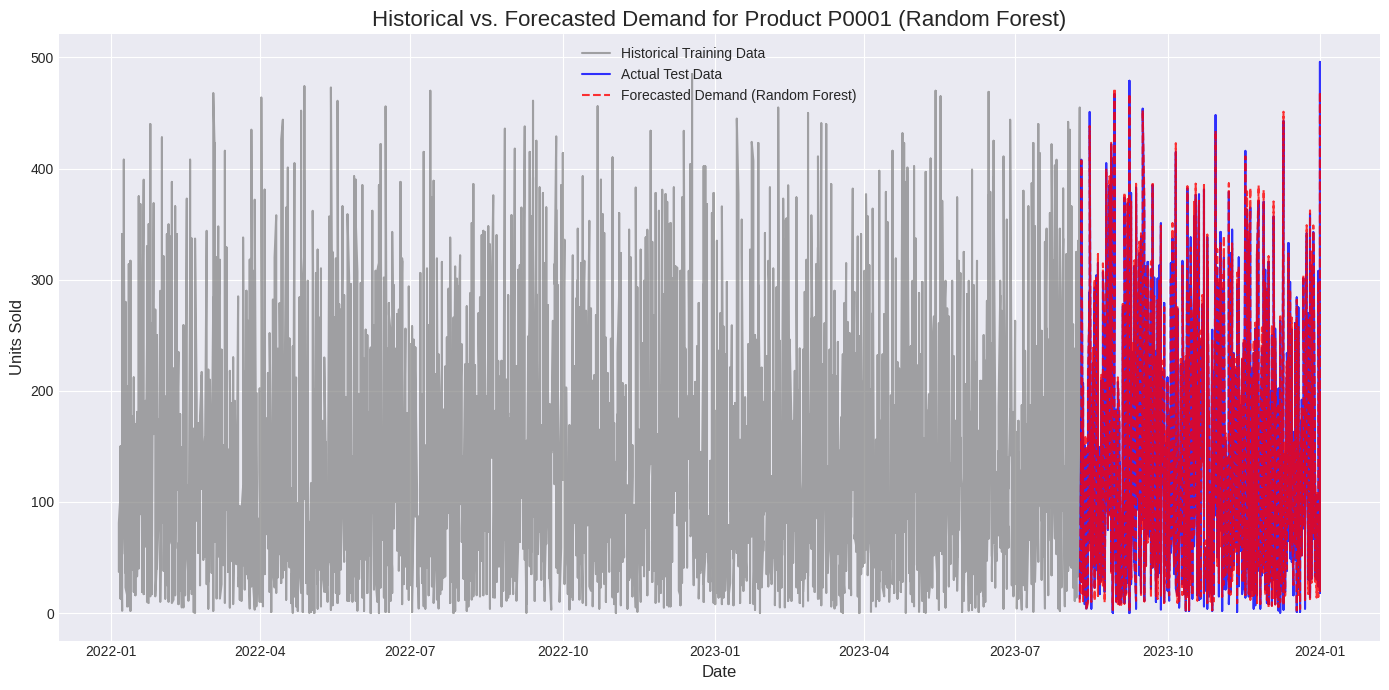

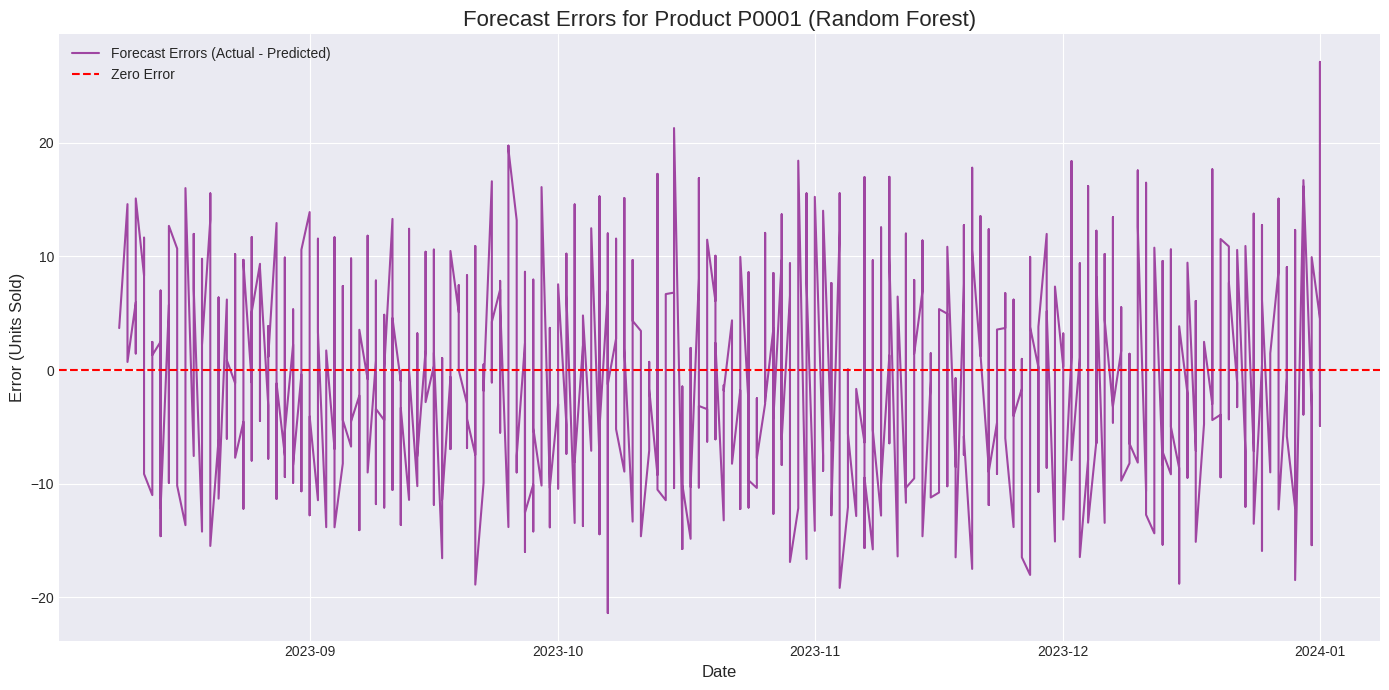


Plots saved to '../results/' folder.
Project execution complete!


In [106]:
# Set plot style for better aesthetics
plt.style.use('seaborn-v0_8-darkgrid')

# Get the full date index for plotting
# Ensure the indices are DatetimeIndex for proper plotting
if not isinstance(y_train.index, pd.DatetimeIndex):
    # This assumes 'Date' column in original df aligns with the index of X/y
    # This is a common way to get the dates back if index was reset or not datetime initially
    full_dates = df['Date'].loc[X.index]
    y_train_plot_index = full_dates.iloc[:len(y_train)]
    y_test_plot_index = full_dates.iloc[len(y_train):]
else:
    y_train_plot_index = y_train.index
    y_test_plot_index = y_test.index


# Plot 1: Historical vs. Forecasted Demand
plt.figure(figsize=(14, 7))
plt.plot(y_train_plot_index, y_train, label='Historical Training Data', color='gray', alpha=0.7)
plt.plot(y_test_plot_index, y_test, label='Actual Test Data', color='blue', alpha=0.8)
plt.plot(y_test_plot_index, predictions_rf, label='Forecasted Demand (Random Forest)', color='red', linestyle='--', alpha=0.8)
plt.title(f'Historical vs. Forecasted Demand for Product {PRODUCT_ID} (Random Forest)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'historical_vs_forecasted_demand_P0001_rf_rerun.png')) # Save with '_rerun'
plt.show()

# Plot 2: Forecast Errors
errors_rf_plot = y_test - predictions_rf
plt.figure(figsize=(14, 7))
plt.plot(y_test_plot_index, errors_rf_plot, label='Forecast Errors (Actual - Predicted)', color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title(f'Forecast Errors for Product {PRODUCT_ID} (Random Forest)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Error (Units Sold)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'forecast_errors_P0001_rf_rerun.png')) # Save with '_rerun'
plt.show()

print(f"\nPlots saved to '{RESULTS_DIR}' folder.")
print("Project execution complete!")